In [1]:
import pandas as pd
k_df=pd.read_json("cleaned_data.json")

In [2]:
k_df.head()

,reportingGroup,locationName,value,unit
2020-01-01 00:00:00,Electricity,1000 Hakaniemen kauppahalli,0.06,kWh
2020-01-01 01:00:00,Electricity,1000 Hakaniemen kauppahalli,0.06,kWh
2020-01-01 02:00:00,Electricity,1000 Hakaniemen kauppahalli,0.06,kWh
2020-01-01 03:00:00,Electricity,1000 Hakaniemen kauppahalli,0.07,kWh
2020-01-01 04:00:00,Electricity,1000 Hakaniemen kauppahalli,0.06,kWh


In [3]:
import pandas as pd

# Convert the timestamp to datetime format
k_df['timestamp'] = pd.to_datetime(k_df.index)

# Now we will group by date and locationName, and sum the values.
k_df['date'] = k_df['timestamp'].dt.date  # Extract date from timestamp

daily_consumption = k_df.groupby(['date', 'locationName'], as_index=False)['value'].sum()

# Display the result
print(daily_consumption)


            date                 locationName  value
0     2020-01-01  1000 Hakaniemen kauppahalli   1.49
1     2020-01-02  1000 Hakaniemen kauppahalli   7.47
2     2020-01-03  1000 Hakaniemen kauppahalli   6.05
3     2020-01-04  1000 Hakaniemen kauppahalli   6.53
4     2020-01-05  1000 Hakaniemen kauppahalli  54.61
...          ...                          ...    ...
1761  2024-10-27  1000 Hakaniemen kauppahalli   0.71
1762  2024-10-28  1000 Hakaniemen kauppahalli  22.59
1763  2024-10-29  1000 Hakaniemen kauppahalli  22.46
1764  2024-10-30  1000 Hakaniemen kauppahalli  21.69
1765  2024-10-31  1000 Hakaniemen kauppahalli   0.02

[1766 rows x 3 columns]


In [4]:
daily_consumption['unique_id']=1

In [5]:
uids = daily_consumption['unique_id'].unique()[:10] # Select 10 ids to make the example faster
new_df = daily_consumption.query('unique_id in @uids')


In [8]:
new_df.head()

,date,locationName,value,unique_id
0,2020-01-01,1000 Hakaniemen kauppahalli,1.49,1
1,2020-01-02,1000 Hakaniemen kauppahalli,7.47,1
2,2020-01-03,1000 Hakaniemen kauppahalli,6.05,1
3,2020-01-04,1000 Hakaniemen kauppahalli,6.53,1
4,2020-01-05,1000 Hakaniemen kauppahalli,54.61,1


In [9]:
start_date = pd.to_datetime('2020-01-01').date()  # Convert to datetime.date
end_date = pd.to_datetime('2024-08-31').date()  

In [21]:
df=daily_consumption[(daily_consumption['date'] >= start_date) & (daily_consumption['date'] <= end_date)]
rest_df=daily_consumption[(daily_consumption['date']) > end_date]

In [22]:
df.head()

,date,locationName,value,unique_id
0,2020-01-01,1000 Hakaniemen kauppahalli,1.49,1
1,2020-01-02,1000 Hakaniemen kauppahalli,7.47,1
2,2020-01-03,1000 Hakaniemen kauppahalli,6.05,1
3,2020-01-04,1000 Hakaniemen kauppahalli,6.53,1
4,2020-01-05,1000 Hakaniemen kauppahalli,54.61,1


In [27]:
rest_df.tail()

,date,locationName,value,unique_id
1761,2024-10-27,1000 Hakaniemen kauppahalli,0.71,1
1762,2024-10-28,1000 Hakaniemen kauppahalli,22.59,1
1763,2024-10-29,1000 Hakaniemen kauppahalli,22.46,1
1764,2024-10-30,1000 Hakaniemen kauppahalli,21.69,1
1765,2024-10-31,1000 Hakaniemen kauppahalli,0.02,1


In [28]:
Y_df = pd.DataFrame({
    'ds': df['date'],  # Timestamps as 'ds'
    'y': df['value'],  # The actual data as 'y'
    'unique_id':df['unique_id']  # The unique identifier

})
check_df= pd.DataFrame({
    'ds': rest_df['date'],  # Timestamps as 'ds'
    'actual': rest_df['value'],  # The actual data as 'y'
    'unique_id':rest_df['unique_id'] } )

In [29]:
Y_df.head()

,ds,y,unique_id
0,2020-01-01,1.49,1
1,2020-01-02,7.47,1
2,2020-01-03,6.05,1
3,2020-01-04,6.53,1
4,2020-01-05,54.61,1


In [30]:
check_df.head()

,ds,actual,unique_id
1705,2024-09-01,77.72,1
1706,2024-09-02,29.78,1
1707,2024-09-03,29.57,1
1708,2024-09-04,31.18,1
1709,2024-09-05,32.76,1


In [31]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS, RNN

In [33]:
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

In [18]:
Y_df.head()

,ds,y,unique_id
0,1970-01-01,1.49,1
1,1970-01-02,7.47,1
2,1970-01-03,6.05,1
3,1970-01-04,6.53,1
4,1970-01-05,54.61,1


In [54]:
horizon = 2*30

# Try different hyperparmeters to improve accuracy.
models = [LSTM(h=horizon,                    # Forecast horizon
               max_steps=1000,                # Number of steps to train
               scaler_type='standard',       # Type of scaler to normalize data
               encoder_hidden_size=64,       # Defines the size of the hidden state of the LSTM
               decoder_hidden_size=64,),     # Defines the number of hidden units of each layer of the MLP decoder
          NHITS(h=horizon,                   # Forecast horizon
                input_size=3 * horizon,      # Length of input sequence
                max_steps=100,               # Number of steps to train
                n_freq_downsample=[2, 1, 1]) # Downsampling factors for each stack output
          ]
nf = NeuralForecast(models=models, freq='D')
nf.fit(df=Y_df)


Seed set to 1
Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 50.4 K | train
4 | context_adapter | Linear        | 78.0 K | train
5 | mlp_decoder     | MLP           | 769    | train
----------------------------------------------------------
129 K     Trainable params
0         Non-trainable params
129 K     Total params
0.517     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.4 M  | train
-------------------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.768    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.


In [55]:
Y_hat_df = nf.predict()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

C:\Users\35841\Desktop\energy_consumption_modeling\energyEV\Lib\site-packages\neuralforecast\core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [56]:
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

,unique_id,ds,LSTM,NHITS
0,1,2024-09-01,24.294689,21.388695
1,1,2024-09-02,26.741085,21.514759
2,1,2024-09-03,24.707884,21.808468
3,1,2024-09-04,25.928743,19.061005
4,1,2024-09-05,31.773386,22.181488


In [57]:
import pandas as pd
import matplotlib.pyplot as plt


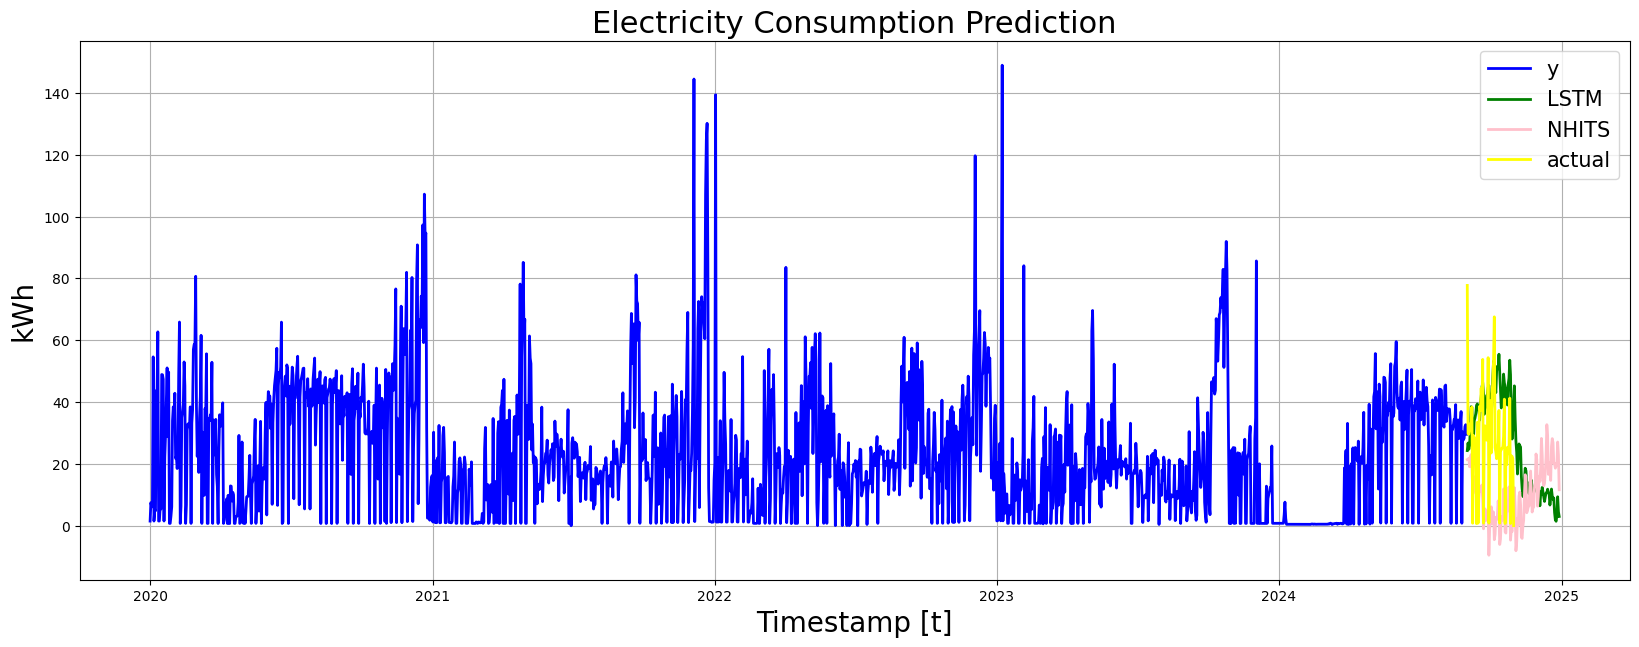

In [58]:
import matplotlib.pyplot as plt

# Define custom colors for each line
custom_colors = ['blue', 'green', 'pink', 'yellow']  # Replace with your preferred colors

fig, ax = plt.subplots(1, 1, figsize=(20, 7))
plot_df = pd.concat([Y_df, Y_hat_df, check_df]).set_index('ds')  # Concatenate the train and forecast dataframes

# Plot with custom colors
plot_df[['y', 'LSTM', 'NHITS', 'actual']].plot(
    ax=ax, linewidth=2, color=custom_colors
)

ax.set_title('Electricity Consumption Prediction', fontsize=22)
ax.set_ylabel('kWh', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()
plt.show()


In [66]:
nf.models[0].train_trajectories

[(0, 0.8110414743423462),
 (1, 0.8082608580589294),
 (2, 0.8055682182312012),
 (3, 0.802930474281311),
 (4, 0.8003328442573547),
 (5, 0.7977634072303772),
 (6, 0.7952167987823486),
 (7, 0.7926720976829529),
 (8, 0.7901267409324646),
 (9, 0.7875894904136658),
 (10, 0.7850477695465088),
 (11, 0.7824794054031372),
 (12, 0.77989262342453),
 (13, 0.7772390246391296),
 (14, 0.7745015621185303),
 (15, 0.7717620730400085),
 (16, 0.7691575884819031),
 (17, 0.7672020792961121),
 (18, 0.7670671343803406),
 (19, 0.7684009671211243),
 (20, 0.768750786781311),
 (21, 0.7679519057273865),
 (22, 0.7666958570480347),
 (23, 0.7655832171440125),
 (24, 0.7648425698280334),
 (25, 0.764395534992218),
 (26, 0.7641008496284485),
 (27, 0.7638289332389832),
 (28, 0.7635036706924438),
 (29, 0.76307612657547),
 (30, 0.7625191807746887),
 (31, 0.7618347406387329),
 (32, 0.7610626220703125),
 (33, 0.7603002786636353),
 (34, 0.7597073316574097),
 (35, 0.7592289447784424),
 (36, 0.7585315108299255),
 (37, 0.7575561404

In [67]:
nf.models[1].train_trajectories

[(0, 19.392650604248047),
 (1, 19.31827735900879),
 (2, 19.147249221801758),
 (3, 18.838010787963867),
 (4, 18.35697364807129),
 (5, 19.282283782958984),
 (6, 18.054729461669922),
 (7, 18.492286682128906),
 (8, 17.783178329467773),
 (9, 17.639373779296875),
 (10, 17.258420944213867),
 (11, 16.683176040649414),
 (12, 17.590314865112305),
 (13, 17.211397171020508),
 (14, 17.47254180908203),
 (15, 16.00984001159668),
 (16, 16.38237762451172),
 (17, 16.275423049926758),
 (18, 15.44727611541748),
 (19, 15.394701957702637),
 (20, 14.962793350219727),
 (21, 15.469839096069336),
 (22, 14.607076644897461),
 (23, 14.40659236907959),
 (24, 13.968395233154297),
 (25, 13.657623291015625),
 (26, 13.533352851867676),
 (27, 13.201391220092773),
 (28, 12.743090629577637),
 (29, 12.546303749084473),
 (30, 13.098402976989746),
 (31, 14.372035026550293),
 (32, 12.336517333984375),
 (33, 15.805509567260742),
 (34, 12.045465469360352),
 (35, 13.30333423614502),
 (36, 13.949084281921387),
 (37, 13.3780994415